In [1]:
import glob
import scipy
import functools
import uproot as up
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import awkward as ak
#import Pool
import multiprocessing as mp
from multiprocessing import Pool, Process, Manager
import tqdm
from scipy import stats
from scipy.stats import gaussian_kde

In [2]:
Uranium_datatypes = ['Bi214','Pb214','Ra226','Pa234[73.920X]','Po218','Bi210','Po210','U238','U234','Th230','Pb210','Th234','Pa234','Pa234Gamma']
Thorium_datatypes = ['Ac228','Pb212','Rn220','Bi212','Ra224','Th228','Po216','Th232','Ra228','Tl208']

top5 = ['Gd152','Bi214','Ac228','Pb212','Pb214']



In [9]:
tfile = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/od_internals/lzap_output/*')
tfile
#display(event.keys())

['/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/amli_csd1_z700mm',
 '/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/amli_neutrons_only_csd1_z700mm',
 '/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/amli_neutrons_only_csd1_z700mm_saved_verbose',
 '/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/background_neutrons_18Jun19',
 '/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/cf252',
 '/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/gd_152_decay',
 '/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/gdls_neutrons',
 '/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/od_1000kev_alpha',
 '/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/od_1000kev_electron',
 '/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/od_1000kev_gamma',
 '/hdfs/user/ak18773/od_simulations/BACCAR

In [4]:
def data_decay(file):
    
    tfile= up.open(file)
    events=tfile["Events"]
    pulsearea=np.array(events["pulsesODHG.pulseArea_phd"])
    pulsearea=pulsearea.flatten()
    af75=np.array(events["pulsesODHG.areaFractionTime75_ns"])
    af75=af75.flatten()
    pulsestart=np.array(events["pulsesODHG.pulseStartTime_ns"])
    pulsestart=pulsestart.flatten()
    pulseend=np.array(events["pulsesODHG.pulseEndTime_ns"])
    pulseend=pulseend.flatten()
    truth = tfile['RQMCTruth']
    pp = np.array(truth['mcTruthEvent./mcTruthEvent.parentParticle'])
    pp=pp.flatten()
    
    return [pulsearea,af75,pulsestart,pulseend,pp]

def data():
    columns={'Pulse_Area' : [], 'af75' : [], 'pulsestart' : [], 'pulseend' : [], 'Tag' : []}
    files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/od_internals/lzap_output/*')
    with mp.Pool(30) as pool:
            data = list(tqdm.tqdm(pool.imap(functools.partial(data_decay),files),total=100))
    data=pd.DataFrame(np.concatenate(data,axis=1).T.tolist(),columns=columns)
    return data


In [5]:
def cut_1D(df,total,min,max,datatype):
    
    cut = df[df['{}'.format(datatype)].between(min, max)]
    totalcut = total[total['{}'.format(datatype)].between(min, max)]
    
    signal = len(cut)
    background = len(totalcut)
    
    confidence = signal/background
    countscovered = signal/len(df.Pulse_Area)
    
    perf = confidence + countscovered
    
    print('purity: '+ str(confidence))
    print('efficiency: '+ str(countscovered))
    print('sum of both: '+ str(perf))

def PDE(signal,background):
    L = L = signal[0]/(signal[0] + background[0])
    centre = [ (y+x)/2 for x, y in zip(signal[1],signal[1][1:]) ]  
    
    return L, centre


In [6]:
data = data()

3000it [01:11, 42.20it/s]                                                                                       


In [7]:


data['pulselength'] = data['pulseend'] - data['pulsestart']

display(data.head())

,Pulse_Area,af75,pulsestart,pulseend,Tag,pulselength
0,[3.6044168],[130],[70],[330],Gd152,[260]
1,[22.544008],[150],[60],[470],Ra224,[410]
2,[15.754724],[180],[40],[410],Rn222,[370]
3,[16.342558],[170],[30],[380],Th228,[350]
4,[],[],[],[],Pb214,[]


In [353]:
data = data.set_index(['Tag']).apply(pd.Series.explode).reset_index()
data = data.dropna()
display(data.head())



,Tag,Pulse_Area,af75,pulsestart,pulseend,pulselength
0,Gd152,3.604417,130,70,330,260
1,Ra224,22.544008,150,60,470,410
2,Rn222,15.754724,180,40,410,370
3,Th228,16.342558,170,30,380,350
4,Pb210,1.681656,80,70,270,200


In [354]:
Gd152=data[data['Tag']=='Gd152']
Bi214=data[data['Tag']=='Bi214']
Ac228=data[data['Tag']=='Ac228']
Pb212=data[data['Tag']=='Pb212']
Pb214=data[data['Tag']=='Pb214']


In [355]:
display(Gd152.head())

,Tag,Pulse_Area,af75,pulsestart,pulseend,pulselength
0,Gd152,3.604417,130,70,330,260
6,Gd152,2.863029,140,70,340,270
8,Gd152,0.462739,70,100,190,90
9,Gd152,2.136728,210,80,400,320
13,Gd152,2.425145,140,100,370,270


In [356]:
Uranium_datatypes = ['Bi214','Pb214','Ra226','Pa234[73.920X]','Po218','Bi210','Po210','U238','U234','Th230','Pb210','Th234','Pa234','Pa234Gamma']
Thorium_datatypes = ['Ac228','Pb212','Rn220','Bi212','Ra224','Th228','Po216','Th232','Ra228','Tl208']

Uranium = data[data['Tag'].isin(Uranium_datatypes)]
Thorium = data[data['Tag'].isin(Thorium_datatypes)]


Uranium = Uranium.drop(Uranium[Uranium.Pulse_Area < 5].index)
Thorium = Thorium.drop(Thorium[Thorium.Pulse_Area < 5].index)

In [357]:
display(Uranium.head())

,Tag,Pulse_Area,af75,pulsestart,pulseend,pulselength
5,Po218,32.394447,140,70,390,320
7,Po218,19.172611,160,70,430,360
11,U238,10.620587,140,70,370,300
12,Bi214,36.003147,150,70,390,320
17,Th230,21.329746,180,30,390,360


In [358]:
alpha_decaytypes = ['U238','U234','Th230','Ra226','Rn222','Po218','Bi214','Po214','Pb210','Bi210','Po210','Th232','Th228','Ra224','Rn220','Po216','Pb212','Bi212','Po212']
beta_decaytypes = ['Th234','Pa234','Pb214','Bi214','Ti210','Pb210','Bi210','Ti206','Ra228','Ac228','Pb212','Bi212','Ti208']


Alpha = data[data['Tag'].isin(alpha_decaytypes)]
Beta = data[data['Tag'].isin(beta_decaytypes)]

Alpha = Alpha.drop(Alpha[Alpha.Pulse_Area < 5].index)
Beta = Beta.drop(Beta[Beta.Pulse_Area < 5].index)



In [359]:
display(Alpha.head())

,Tag,Pulse_Area,af75,pulsestart,pulseend,pulselength
1,Ra224,22.544008,150,60,470,410
2,Rn222,15.754724,180,40,410,370
3,Th228,16.342558,170,30,380,350
5,Po218,32.394447,140,70,390,320
7,Po218,19.172611,160,70,430,360


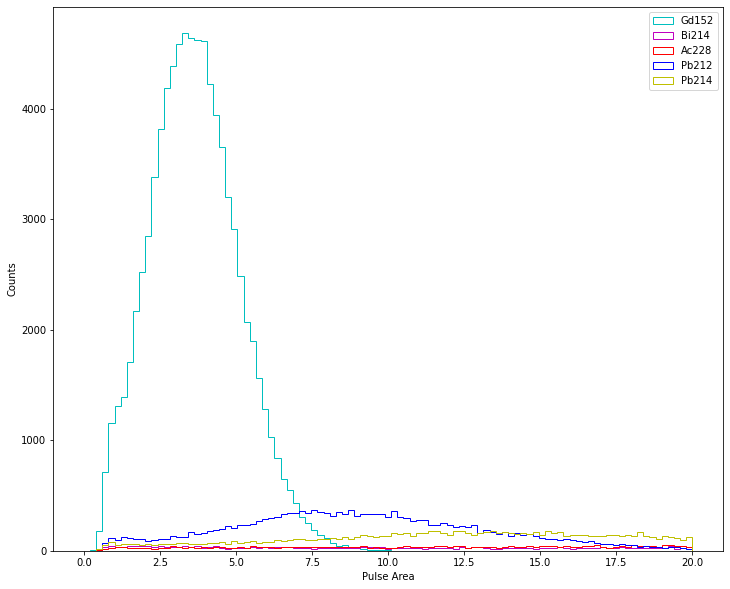

In [370]:

bins = np.linspace(0,20,100)


fig, ax = plt.subplots(figsize=(12,10))

ax.hist(Gd152.Pulse_Area, bins, label='Gd152', color='c', histtype = 'step')
ax.hist(Bi214.Pulse_Area, bins, label='Bi214', color='m', histtype = 'step')
ax.hist(Ac228.Pulse_Area, bins, label='Ac228', color='r', histtype = 'step')
ax.hist(Pb212.Pulse_Area, bins, label='Pb212', color='b', histtype = 'step')
ax.hist(Pb214.Pulse_Area, bins, label='Pb214',color='y', histtype = 'step')

ax.set_xlabel('Pulse Area')
ax.set_ylabel('Counts')
plt.legend()
plt.show()

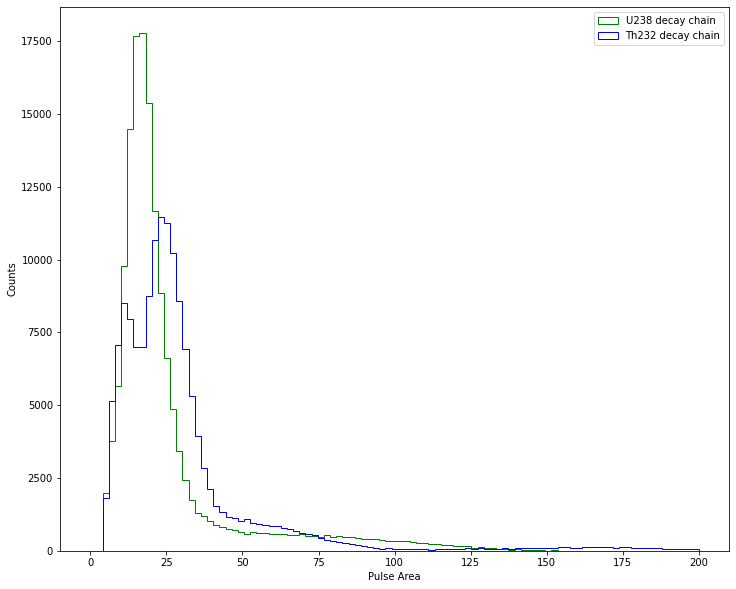

In [361]:

bins = np.linspace(0,200,100)


fig, ax = plt.subplots(figsize=(12,10))

ax.hist(Uranium.Pulse_Area, bins, label='U238 decay chain', color='g', histtype = 'step')
ax.hist(Thorium.Pulse_Area, bins, label='Th232 decay chain', color='b', histtype = 'step')

ax.set_xlabel('Pulse Area')
ax.set_ylabel('Counts')

plt.legend()
plt.show()

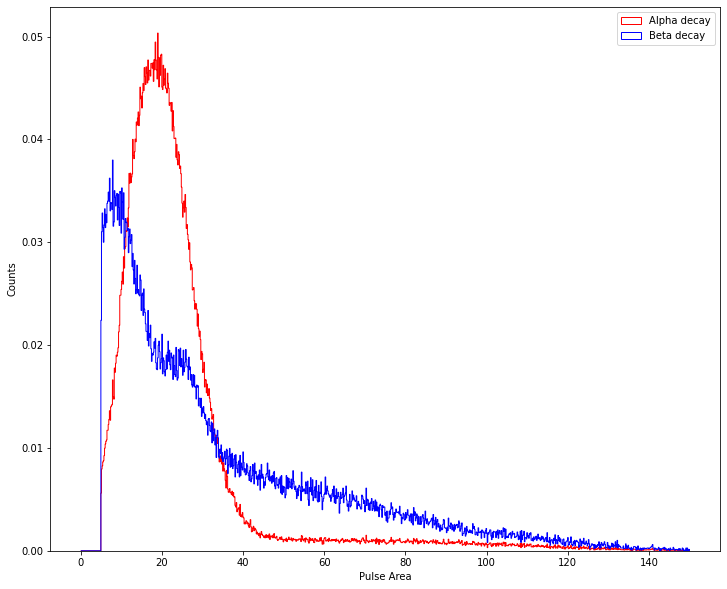

In [395]:
bins = np.linspace(0,150,1000)


fig, ax = plt.subplots(figsize=(12,10))

signal = ax.hist(Alpha.Pulse_Area, bins, label='Alpha decay', color='r', histtype = 'step',density = True)
background = ax.hist(Beta.Pulse_Area, bins, label='Beta decay', color='b', histtype = 'step',density = True)

ax.set_xlabel('Pulse Area')
ax.set_ylabel('Counts')

plt.legend()
plt.show()


In [396]:
total = pd.concat([Alpha,Beta])
cut_1D(Alpha,total,0,150,'Pulse_Area')

purity: 0.725354532173952
efficiency: 0.9997843981242637
sum of both: 1.7251389302982156


/tmp/ipykernel_99634/2567913488.py:19: RuntimeWarning: invalid value encountered in true_divide
  L = L = signal[0]/(signal[0] + background[0])


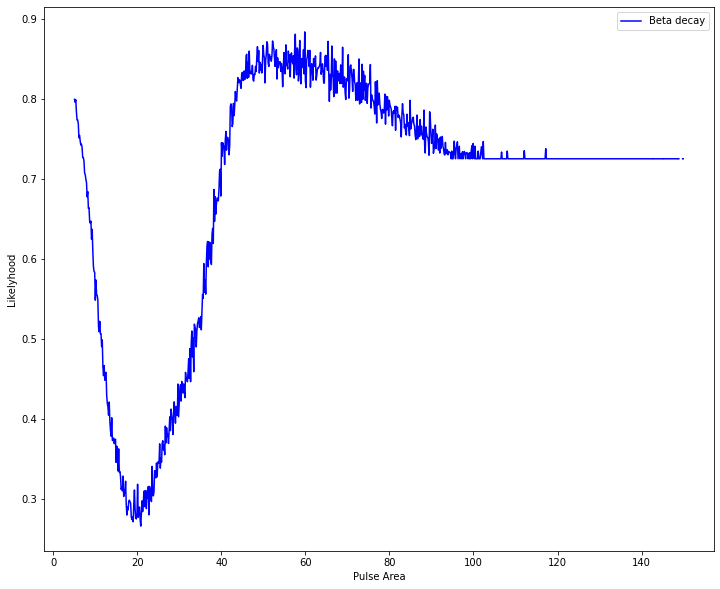

In [399]:
L, centre = PDE(background,signal)

fig, ax = plt.subplots(figsize=(12,10))

ax.plot(centre, L, color = 'b', label='Beta decay')

ax.set_xlabel('Pulse Area')
ax.set_ylabel('Likelyhood')
plt.legend()
plt.show()

In [290]:
poladium_datatypes = ['Po210','Po218','Po216','Po215']
bismuth_datatypes = ['Bi214','Bi210']

poladium = data[data['Tag'].isin(poladium_datatypes)]
bismuth = data[data['Tag'].isin(bismuth_datatypes)]



,Tag,Pulse_Area,af75,pulsestart,pulseend
6,Po218,32.394447,140,70,390
8,Po218,19.172611,160,70,430
30,Po218,24.12594,140,60,370
32,Po210,23.664164,130,70,360
39,Po218,28.037792,170,40,360


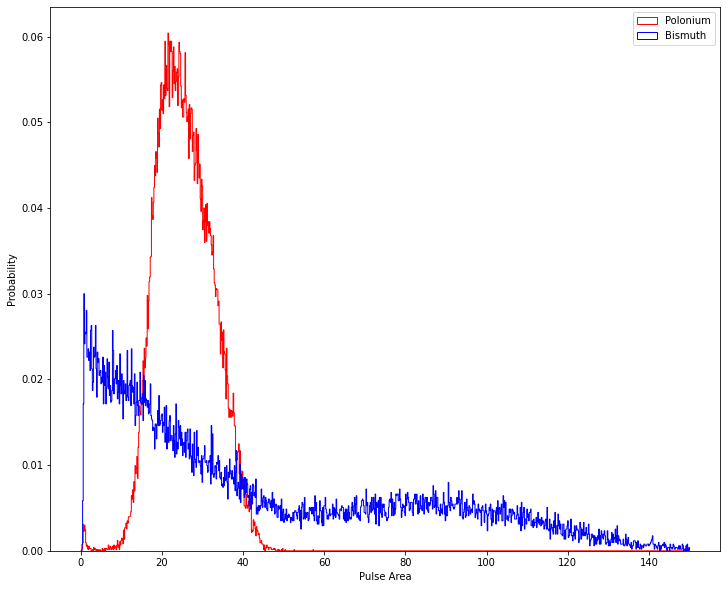

In [377]:
bins = np.linspace(0,150,1000)


fig, ax = plt.subplots(figsize=(12,10))

signal = ax.hist(poladium.Pulse_Area, bins, label='Polonium', color='r', histtype = 'step',density = True)
background = ax.hist(bismuth.Pulse_Area, bins, label='Bismuth', color='b', histtype = 'step',density = True)

ax.set_xlabel('Pulse Area')
ax.set_ylabel('Probability')

plt.legend()
plt.show()

In [333]:
total = pd.concat([poladium,bismuth])
cut_1D(bismuth,total,0,13,'Pulse_Area')
cut_1D(bismuth,total,40,140,'Pulse_Area')
print('===============')
cut_1D(poladium,total,13,40,'Pulse_Area')


purity: 0.9234554973821989
efficiency: 0.2575266462257264
sum of both: 1.1809821436079253
purity: 0.9380561026964613
efficiency: 0.4032997517885823
sum of both: 1.3413558544850437
purity: 0.8080304510391754
efficiency: 0.9668876841532478
sum of both: 1.774918135192423


/tmp/ipykernel_99634/2567913488.py:19: RuntimeWarning: invalid value encountered in true_divide
  L = L = signal[0]/(signal[0] + background[0])


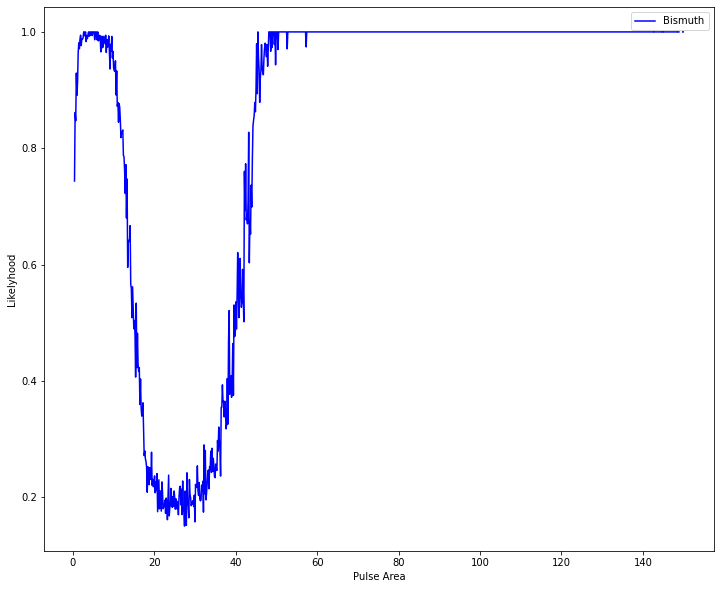

In [385]:
L, centre = PDE(background,signal)

fig, ax = plt.subplots(figsize=(12,10))

ax.plot(centre, L, color = 'b', label='Bismuth')

ax.set_xlabel('Pulse Area')
ax.set_ylabel('Likelyhood')
plt.legend()
plt.show()